In [1]:
import numpy as np
import pandas as pd
import time

d = pd.read_csv("temp.csv")
d.head()

,PD1,GzmB,CD8a,CD103,CD56,CD25,CD4,CD19,CD49a,CD3,FoxP3
0,1.760079,2.241769,0.447316,0.951417,1.085694,0.365136,1.159030,0.744424,1.756490,1.208541,0.897291
1,2.504053,1.743894,0.725944,1.063522,1.146853,0.924040,2.429543,1.594169,3.008561,1.925828,0.740108
2,1.171469,1.729824,0.942350,0.670537,1.141923,0.644870,0.998817,0.800615,1.419161,1.141207,0.937181
3,1.464891,1.908043,0.499899,0.927789,0.677614,1.049692,0.864599,0.746302,1.478173,1.268048,0.886642
4,1.989203,1.786417,0.857825,0.784642,0.617290,1.169930,0.363880,0.945732,1.475951,1.183369,0.803843


## Gaussian Mixture Model

In [2]:
# hierarchical GMM
from sklearn.mixture import GaussianMixture

def gmm_gate(d,colname,ncomp=2):
    temp = d[colname].to_numpy().reshape(-1,1)
    gmm = GaussianMixture(n_components=ncomp).fit(temp)
    labels = gmm.predict(temp)
    # sort labels by gmm mean values
    mapping = dict(zip( list(range(len(gmm.means_))),list(np.argsort(np.squeeze(gmm.means_))) ))
    labels = np.asarray([mapping[x] for x in labels])
    return labels

def gmm_classify(d,gatename):
    cols = d[gatename].columns
    [m,n] = d[gatename].shape
    ncomp = 2*np.ones(n,dtype=int)
    ncomp[list(cols).index('CD56')] = 3
    
    print('\nIn {}:'.format(gatename))
    for i in range(n):
        temp = d[gatename][cols[i]].to_numpy().reshape(-1,1)
        gmm = GaussianMixture(n_components=ncomp[i]).fit(temp)
        probs = gmm.predict_proba(temp)
        isconfident = np.any(probs>thresh,axis=1)
        print('For {}, confident classification: {} %'.format(cols[i],round(np.sum(isconfident)/m*100,2)))

In [3]:
# gating operation
cols = d.columns
[m,n] = d.shape
gate = {}

gate['All'] = d

labels = gmm_gate(d,'CD3')
gate['CD3+'] = d.iloc[np.where(labels==1)].reset_index(drop=True)
gate['CD3-'] = d.iloc[np.where(labels==0)].reset_index(drop=True)

labels = gmm_gate(gate['CD3-'],'CD4')
gate['CD3-CD4+'] = gate['CD3-'].iloc[np.where(labels==1)].reset_index(drop=True)

labels = gmm_gate(gate['CD3+'],'CD4')
gate['CD3+CD4+'] = gate['CD3+'].iloc[np.where(labels==1)].reset_index(drop=True)

labels = gmm_gate(gate['CD3+'],'CD8a')
gate['CD3+CD8+'] = gate['CD3+'].iloc[np.where(labels==1)].reset_index(drop=True)

labels = gmm_gate(gate['CD3+CD4+'],'CD49a')
gate['CD3+CD4+CD49+'] = gate['CD3+CD4+'].iloc[np.where(labels==1)].reset_index(drop=True)

labels = gmm_gate(gate['CD3+CD8+'],'CD103')
gate['CD3+CD8+CD103+'] = gate['CD3+CD8+'].iloc[np.where(labels==1)].reset_index(drop=True)

labels = gmm_gate(gate['CD3+CD8+'],'CD4')
gate['CD3+CD8+CD4+'] = gate['CD3+CD8+'].iloc[np.where(labels==1)].reset_index(drop=True)

for gatename in gate.keys():
    print('{}: {} %'.format(gatename,round(gate[gatename].shape[0]/m*100,2)))

All: 100.0 %
CD3+: 35.8 %
CD3-: 64.2 %
CD3-CD4+: 7.09 %
CD3+CD4+: 25.15 %
CD3+CD8+: 9.99 %
CD3+CD4+CD49+: 13.27 %
CD3+CD8+CD103+: 3.43 %
CD3+CD8+CD4+: 1.04 %


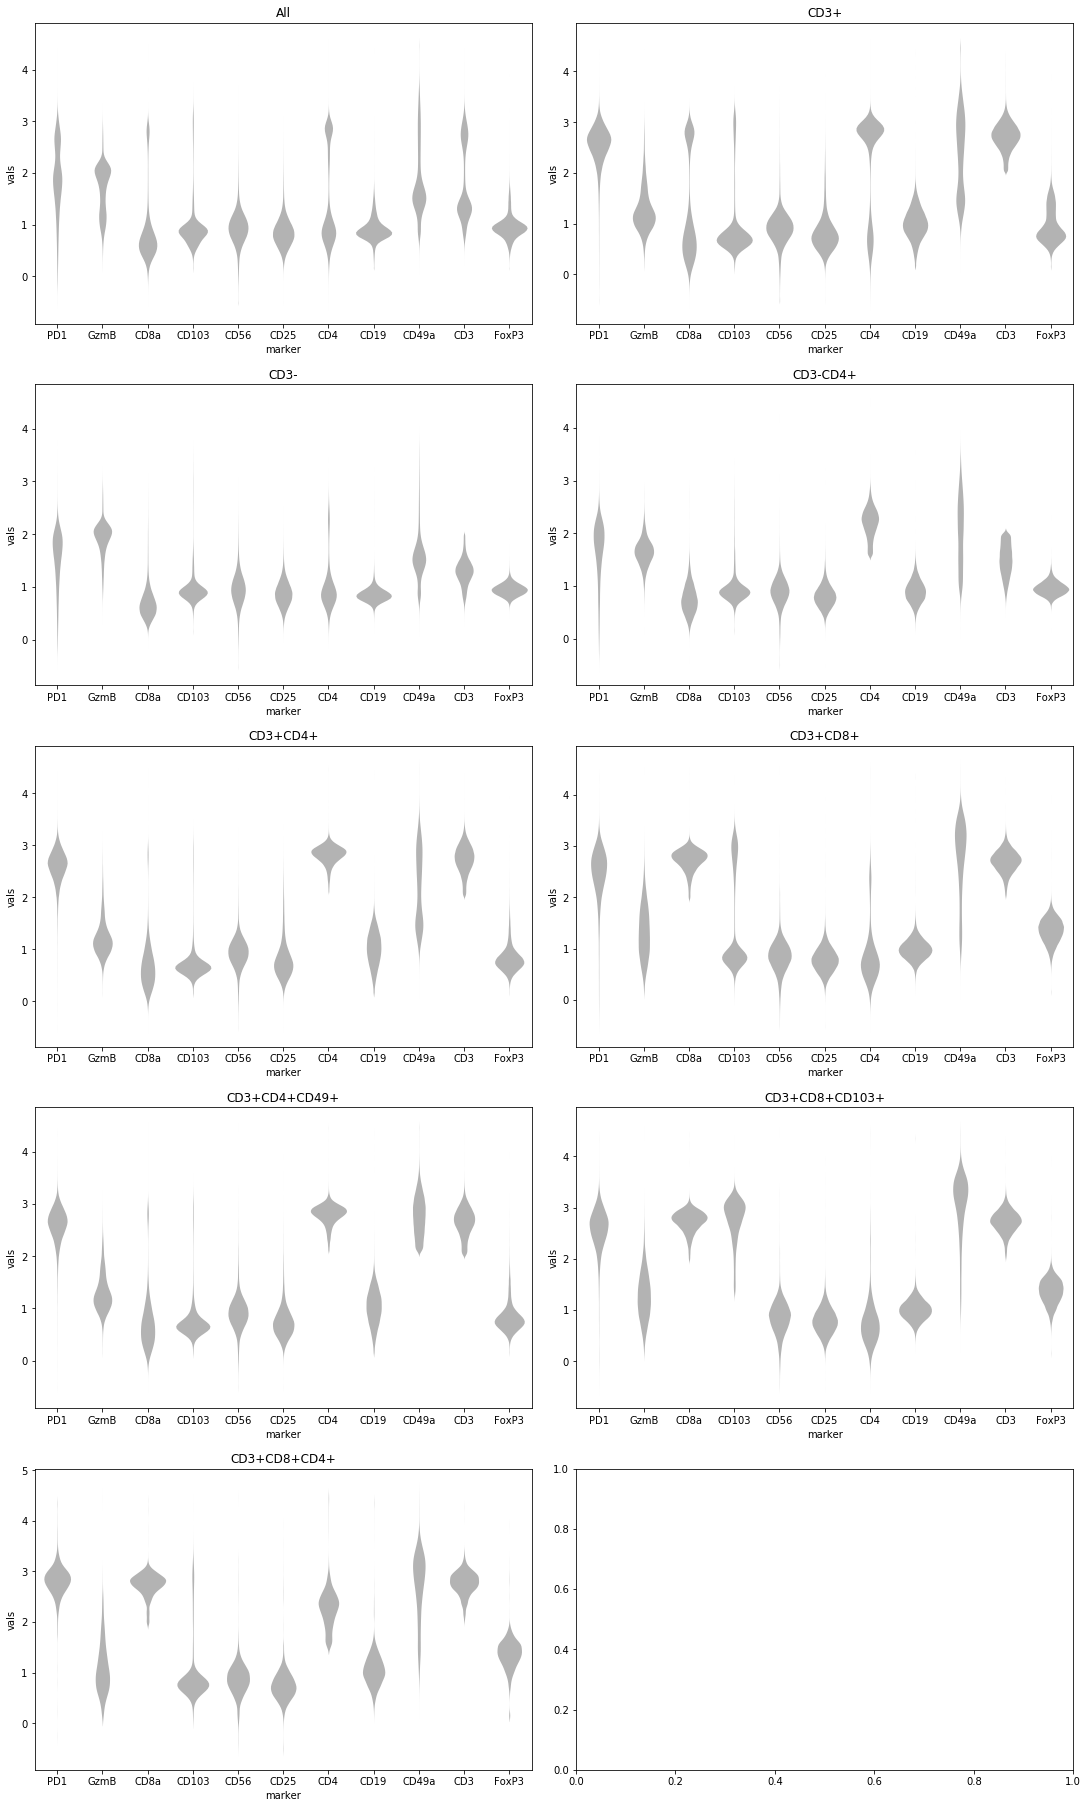

In [6]:
# gate level marker distributions
import seaborn as sb
import matplotlib.pyplot as plt

row = 5
fig, ax = plt.subplots(row, 2, constrained_layout=True, figsize=(15, row*5))

for i,gatename in enumerate(gate.keys()):
    sb.violinplot(x='marker', y='vals', data=gate[gatename].melt(var_name='marker', value_name='vals'),
                  color=(0.7,0.7,0.7), linewidth=0, inner=None, ax = ax[i//2,i%2])
    ax[i//2,i%2].set_title(gatename)

In [5]:
# confident classification
thresh=0.9

gatename = 'All'
gmm_classify(gate,gatename)

gatename = 'CD3+'
gmm_classify(gate,gatename)

gatename = 'CD3+CD4+'
gmm_classify(gate,gatename)

gatename = 'CD3+CD8+'
gmm_classify(gate,gatename)

gatename = 'CD3-'
gmm_classify(gate,gatename)


In All:
For PD1, confident classification: 23.33 %
For GzmB, confident classification: 84.36 %
For CD8a, confident classification: 99.11 %
For CD103, confident classification: 96.12 %
For CD56, confident classification: 1.87 %
For CD25, confident classification: 4.17 %
For CD4, confident classification: 99.22 %
For CD19, confident classification: 23.53 %
For CD49a, confident classification: 90.65 %
For CD3, confident classification: 98.05 %
For FoxP3, confident classification: 87.22 %

In CD3+:
For PD1, confident classification: 80.92 %
For GzmB, confident classification: 67.2 %
For CD8a, confident classification: 99.55 %
For CD103, confident classification: 98.83 %
For CD56, confident classification: 2.1 %
For CD25, confident classification: 78.68 %
For CD4, confident classification: 99.49 %
For CD19, confident classification: 14.1 %
For CD49a, confident classification: 86.49 %
For CD3, confident classification: 21.33 %
For FoxP3, confident classification: 82.7 %

In CD3+CD4+:
For PD

In [7]:
# Let's take the CD3+CD4+ gate and explore marker correlations using posterior prob affine space
gatename = 'CD3+CD4+'
prob_space = pd.DataFrame(columns=gate[gatename].columns)

for i in range(gate[gatename].shape[1]):
    temp = gate[gatename].iloc[:,i].to_numpy().reshape(-1,1)
    gmm = GaussianMixture(n_components=2).fit(temp)
    probs = gmm.predict_proba(temp)
    # pick out prob column corresponding to maximum gmm mean (+ population) for the affine space
    mapping = dict(zip( list(range(len(gmm.means_))),list(np.argsort(np.squeeze(gmm.means_))) ))
    prob_space.iloc[:,i] = probs[:,max(mapping, key=mapping.get)]

In [9]:
from bokeh.plotting import output_notebook, figure, show
output_notebook()

p = figure(width=500, height=500)
v1 = 'CD8a'
v2 = 'PD1'
p.circle(prob_space[v1],prob_space[v2])
p.xaxis.axis_label = v1
p.yaxis.axis_label = v2
show(p)

Loading BokehJS ...

## Louvain Clustering

In [17]:
import scanpy as sc
import anndata
import igraph
d = d.iloc[:,:11]
adata = anndata.AnnData(X=pd.DataFrame.to_numpy(d), obs=list(d.index.values), var=list(d.columns.values))
adata

AnnData object with n_obs × n_vars = 818476 × 11 
    obs: 0
    var: 0

In [ ]:
print("Nearest neighbours...")
start = time.time()
sc.pp.neighbors(adata, n_neighbors=65)
print("DONE: {} s".format(time.time()-start))
print("Louvain clustering...")
mid = time.time()
sc.tl.louvain(adata, resolution=0.1)
print("DONE: {} s".format(time.time()-mid))
print("Number of clusters: ",max(np.array(adata.obs['louvain']).astype(int)+1))
d['cluster']=np.array(adata.obs['louvain']).astype(int)+1
d.to_csv("temp.csv", index=False)

Nearest neighbours...


C:\Users\adity\Anaconda3\lib\site-packages\numba\compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\Anaconda3\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


DONE: 916.7458536624908 s
Louvain clustering...
